In [ ]:
import torch


if torch.cuda.is_available():
    device = torch.device("cuda")
    print('有%d个GPU可用。' % torch.cuda.device_count())
    print('我们将使用GPU:', torch.cuda.get_device_name(0))
else:
    print('没有可用的GPU，使用CPU。')
    device = torch.device("cpu")


没有可用的GPU，使用CPU。


In [ ]:
import pandas as pd
from google.colab import drive
import os
drive = drive.mount('/content/drive/')

folder_path = '/content/drive/MyDrive/Colab_Notebooks/hackthon/'  # Adjust the path as needed

# List the contents of the folder
folder_contents = os.listdir(folder_path)



# 加载数据集
df = pd.read_csv(folder_path+"train.csv")

# 查看前几行数据
print(df.head())
print('训练数据的数量: {:,}\n'.format(df.shape[0]))


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
   id                                               text  label
0   0  This movie is a journey through the mind of a ...      1
1   1  'Water' (2005), the final part of Toronto-base...      1
2   2  This, which was shown dubbed in Italian at a R...      1
3   3  Well, on the day that Rob Schneider plunges hi...      1
4   4  I was watching an NFL game and started surfing...      1
训练数据的数量: 30,000



In [ ]:
import re

def clean_text(text):
    text = re.sub(r'<[^>]+>', '', text)  # 去除 HTML 标签
    text = re.sub(r'http\S+|www\S+', '', text)  # 去除 URL
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # 保留字母和空格
    text = re.sub(r'\s+', ' ', text).strip()  # 去除多余空格
    return text.lower()  # 转换为小写


df['text'] = df['text'].apply(clean_text)


In [ ]:
# 提取句子和标签
sentences = df['text'].values
labels = df['label'].values

# 将标签转换为整数类型
labels = labels.astype(int)


In [ ]:
# from transformers import BertTokenizer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# 加载 BERT 分词器
print('正在加载 BERT 分词器...')
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

正在加载 BERT 分词器...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# 设置最大序列长度
MAX_LEN = 160  # 可以根据数据的平均长度进行调整
# 对句子进行编码
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # 输入文本
                        add_special_tokens = True, # 添加 '[CLS]' 和 '[SEP]'
                        max_length = MAX_LEN,      # 填充和截断长度
                        padding='max_length',
                        truncation=True,
                        return_attention_mask = True,   # 返回 attention masks
                        return_tensors = 'pt',     # 返回 PyTorch tensors 格式
                   )

    # 将编码后的文本加入列表
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# 将列表转换为 tensor
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)


In [ ]:
from sklearn.model_selection import train_test_split

# 将数据集划分为训练集和验证集
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, labels, random_state=42, test_size=0.1
)
train_masks, validation_masks, _, _ = train_test_split(
    attention_masks, labels, random_state=42, test_size=0.1
)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# 定义批量大小
batch_size = 32  # 根据显存大小进行调整

# 创建训练集的 DataLoader
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# 创建验证集的 DataLoader
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)


# 将模型加载到 GPU 中
model.to(device)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
from transformers import get_linear_schedule_with_warmup,AdamW

# 设置优化器
optimizer = AdamW(
    model.parameters(),
    lr = 2e-5,          # 学习率
    eps = 1e-8          # AdamW 优化器的 epsilon 值
)

# 训练轮数
epochs = 10

# 总的训练步骤
total_steps = len(train_dataloader) * epochs

# 设置学习率调度器
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    将时间转换为 hh:mm:ss 形式
    '''
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
import random

# 设置随机种子
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 存储损失值
loss_values = []


best_eval_accuracy = 0
patience = 2  # 容忍的连续性能不提升的 epoch 数
patience_counter = 0




for epoch_i in range(0, epochs):

    print('')
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_loss = 0

    # 将模型设置为训练模式
    model.train()

    # 训练数据循环
    for step, batch in enumerate(train_dataloader):
        # 每隔40个batch输出进度
        print('in the batch{}'.format(step))
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 将数据加载到 GPU 中
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # 清零梯度
        model.zero_grad()

        # 前向传播
        outputs = model(
            b_input_ids,
            attention_mask=b_input_mask,
            labels=b_labels
        )

        # 获取损失值
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()

        # 反向传播
        loss.backward()

        # 梯度裁剪
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 更新参数和学习率
        optimizer.step()
        scheduler.step()

    # 计算平均损失
    avg_train_loss = total_loss / len(train_dataloader)

    loss_values.append(avg_train_loss)
    print('')
    print('  平均训练损失: {0:.2f}'.format(avg_train_loss))
    print('  训练 epoch 耗时: {:}'.format(format_time(time.time() - t0)))

    # ========================================
    #               验证
    # ========================================
    print('')
    print('Running Validation...')

    t0 = time.time()

    # 设置模型为评估模式
    model.eval()

    eval_accuracy = 0
    nb_eval_steps = 0





    # 验证数据循环
    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)

        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(
                b_input_ids,
                attention_mask=b_input_mask
            )

        logits = outputs.logits

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        eval_accuracy += tmp_eval_accuracy

        nb_eval_steps += 1
    eval_accuracy = eval_accuracy / nb_eval_steps

    if eval_accuracy > best_eval_accuracy:
      best_eval_accuracy = eval_accuracy
      patience_counter = 0
      # 保存模型
      # model.save_pretrained(output_dir)
      # tokenizer.save_pretrained(output_dir)
    else:
      patience_counter += 1
      if patience_counter >= patience:
          print('Early stopping due to no improvement in validation accuracy.')
          break

    print('  准确率: {0:.2f}'.format(eval_accuracy))
    print('  验证耗时: {:}'.format(format_time(time.time() - t0)))

print('')
print('训练完成！')



======== Epoch 1 / 10 ========
Training...
in the batch0
in the batch1
in the batch2
in the batch3
in the batch4
in the batch5
in the batch6
in the batch7
in the batch8
in the batch9
in the batch10
in the batch11
in the batch12
in the batch13
in the batch14
in the batch15
in the batch16
in the batch17
in the batch18
in the batch19
in the batch20
in the batch21
in the batch22
in the batch23
in the batch24
in the batch25
in the batch26
in the batch27
in the batch28
in the batch29
in the batch30
in the batch31
in the batch32
in the batch33
in the batch34
in the batch35
in the batch36
in the batch37
in the batch38
in the batch39
in the batch40
  Batch    40  of    844.    Elapsed: 0:18:03.
in the batch41
in the batch42
in the batch43
in the batch44
in the batch45
in the batch46
in the batch47
in the batch48
in the batch49
in the batch50
in the batch51
in the batch52
in the batch53
in the batch54
in the batch55
in the batch56
in the batch57
in the batch58
in the batch59
in the batch60
in t

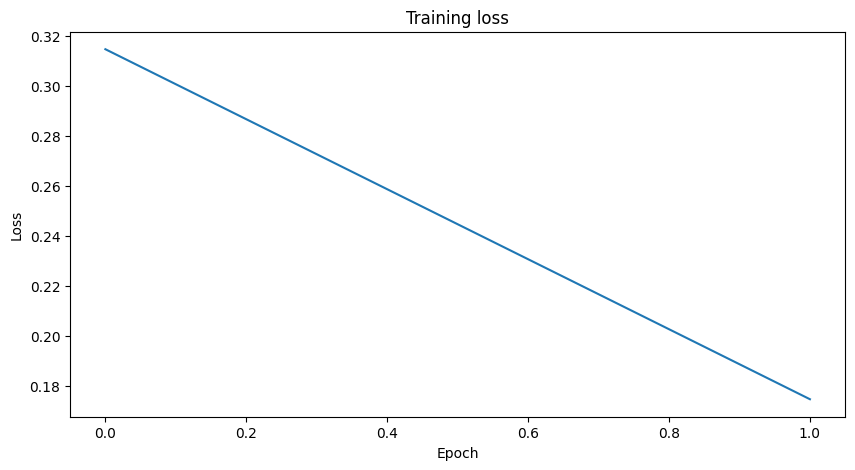

In [ ]:
import matplotlib.pyplot as plt

# 绘制训练损失曲线
plt.figure(figsize=(10,5))
plt.title("Training loss")
plt.plot(loss_values)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [ ]:
output_dir = folder_path +'/model_2_save/'

# 创建输出目录
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print('Saving model to %s' % output_dir)

# 保存模型和分词器
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


Saving model to /content/drive/MyDrive/Colab_Notebooks/hackthon//model_save/


('/content/drive/MyDrive/Colab_Notebooks/hackthon//model_save/tokenizer_config.json',
 '/content/drive/MyDrive/Colab_Notebooks/hackthon//model_save/special_tokens_map.json',
 '/content/drive/MyDrive/Colab_Notebooks/hackthon//model_save/vocab.txt',
 '/content/drive/MyDrive/Colab_Notebooks/hackthon//model_save/added_tokens.json')

In [ ]:
import torch.quantization

# 将模型移动到 CPU
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

# 从 output_dir 加载未量化的模型和分词器
model = DistilBertForSequenceClassification.from_pretrained(output_dir)
tokenizer = DistilBertTokenizer.from_pretrained(output_dir)

# 将模型移动到 CPU，因为量化通常在 CPU 上进行
model_cpu = model.cpu()

# 对模型进行动态量化
quantized_model = torch.quantization.quantize_dynamic(
    model_cpu,
    {torch.nn.Linear},
    dtype=torch.qint8
)

# 保存量化后的模型
quantized_model_save_path = os.path.join(output_dir, 'quantized_model.pth')
torch.save(quantized_model.state_dict(), quantized_model_save_path)
print('量化后的模型已保存到 %s' % quantized_model_save_path)
# tokenizer.save_pretrained(output_dir)
# print('分词器已保存到 %s' % output_dir)


In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained(output_dir)
tokenizer = DistilBertTokenizer.from_pretrained(output_dir)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
def predict(sentence):
    # 对输入句子进行编码
    encoded_dict = tokenizer.encode_plus(
                        sentence,                   # 输入句子
                        add_special_tokens = True,  # 添加 '[CLS]' 和 '[SEP]'
                        max_length = MAX_LEN,       # 填充和截断长度
                        padding='max_length',
                        truncation=True,
                        return_attention_mask = True,
                        return_tensors = 'pt',      # 返回 PyTorch tensors 格式
                   )

    # 将数据移动到 GPU
    input_id = encoded_dict['input_ids'].to(device)
    attention_mask = encoded_dict['attention_mask'].to(device)

    # 设置模型为评估模式
    model.eval()

    with torch.no_grad():
        outputs = model(input_id, attention_mask=attention_mask)

    logits = outputs.logits

    # 获取预测结果
    logits = logits.detach().cpu().numpy()
    prediction = np.argmax(logits, axis=1).flatten()

    if prediction == 0:
        print("Negative")
    else:
        print("Positive")

# 测试示例
predict("This movie is fantastic! I really enjoyed it.")


Positive


In [ ]:
import torch.quantization

# 将模型移动到 CPU
model_cpu = model.cpu()

# 对模型进行动态量化
quantized_model = torch.quantization.quantize_dynamic(
    model_cpu,
    {torch.nn.Linear},
    dtype=torch.qint8
)

# 保存量化后的模型
quantized_model_save_path = os.path.join(output_dir, 'quantized_model.pth')
torch.save(quantized_model, quantized_model_save_path)
print('量化后的模型已保存到 %s' % quantized_model_save_path)


In [ ]:
quantized_model_save_path = os.path.join(output_dir, 'quantized_model.pth')

In [ ]:
teacher_model_dir = output_dir
student_model_dir = output_dir+'student'
if not os.path.exists(student_model_dir):
    os.makedirs(student_model_dir)

teacher_model = DistilBertForSequenceClassification.from_pretrained(teacher_model_dir)
teacher_model.to('cpu')  # 教师模型在 CPU 上
teacher_model.eval()
for param in teacher_model.parameters():
    param.requires_grad = False

# 定义学生模型配置（更小的模型）
student_config = DistilBertConfig(
    n_layers=3,                 # 减少层数
    dim=256,                    # 减少隐藏层维度
    n_heads=4,                  # 减少注意力头数
    dim_feedforward=1024,       # 维持前馈层大小
    dropout=0.1,                # Dropout 率
    max_position_embeddings=160,# 与输入长度一致
    n_labels=2                  # 根据任务调整
)

# 初始化学生模型
student_model = DistilBertForSequenceClassification(student_config)
student_model.to(device)

# 加载分词器
tokenizer = DistilBertTokenizer.from_pretrained(teacher_model_dir)

# 编码训练数据
train_encodings = tokenizer.batch_encode_plus(
    train_df['text'].tolist(),
    add_special_tokens=True,
    max_length=160,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)
def distillation_loss(student_logits, teacher_logits, labels, T=2.0, alpha=0.5):
    """
    计算蒸馏损失。

    参数：
    - student_logits: 学生模型的输出 logits
    - teacher_logits: 教师模型的输出 logits
    - labels: 真实标签
    - T: 温度参数
    - alpha: 蒸馏损失的权重
    """
    # 计算蒸馏损失（KL散度）
    loss_kd = F.kl_div(
        F.log_softmax(student_logits / T, dim=1),
        F.softmax(teacher_logits / T, dim=1),
        reduction='batchmean'
    ) * (T ** 2)

    # 计算分类损失（交叉熵）
    loss_ce = F.cross_entropy(student_logits, labels)

    # 总损失
    loss = alpha * loss_ce + (1. - alpha) * loss_kd
    return loss


for epoch_i in range(epochs):
    print('')
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')
    print('Training...')

    t0 = time.time()
    total_loss = 0

    # 将学生模型设置为训练模式
    student_model.train()

    # 训练数据循环
    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = time.time() - t0
            print(f'  Batch {step} of {len(train_dataloader)}.    Elapsed: {elapsed:.2f} seconds.')

        # 获取输入数据并移动到设备
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # 清零梯度
        optimizer.zero_grad()

        # 教师模型输出（在 CPU 上，无需计算梯度）
        with torch.no_grad():
            outputs_teacher = teacher_model(
                batch[0].to('cpu'),             # 输入数据移动到 CPU
                attention_mask=batch[1].to('cpu')  # 注意力掩码移动到 CPU
            )
            logits_teacher = outputs_teacher.logits

        # 学生模型输出（在 GPU 上）
        outputs_student = student_model(
            b_input_ids,
            attention_mask=b_input_mask
        )
        logits_student = outputs_student.logits

        # 将教师模型的 logits 移动到 GPU
        logits_teacher = logits_teacher.to(device)

        # 计算蒸馏损失
        loss = distillation_loss(
            logits_student,
            logits_teacher,
            b_labels,
            T=2.0,
            alpha=0.5
        )

        # 反向传播
        loss.backward()

        # 梯度裁剪
        torch.nn.utils.clip_grad_norm_(student_model.parameters(), 1.0)

        # 更新参数和学习率
        optimizer.step()
        scheduler.step()

        # 累加损失值
        total_loss += loss.item()

    # 计算平均训练损失
    avg_train_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_train_loss)

    print('')
    print(f'  平均训练损失: {avg_train_loss:.2f}')
    print(f'  训练 epoch 耗时: {time.time() - t0:.2f} seconds')

    # ========================================
    #               验证
    # ========================================
    print('')
    print('Running Validation...')

    t0 = time.time()

    # 设置学生模型为评估模式
    student_model.eval()

    eval_accuracy = 0
    nb_eval_steps = 0

    # 验证数据循环
    with torch.no_grad():
        for batch in validation_dataloader:
            batch_input_ids = batch[0].to(device)
            batch_attention_mask = batch[1].to(device)
            batch_labels = batch[2].to(device)

            # 学生模型输出
            outputs = student_model(
                batch_input_ids,
                attention_mask=batch_attention_mask
            )
            logits = outputs.logits

            # 将 logits 转换为 FP32 以提高数值稳定性
            logits = logits.float()

            # 获取预测结果
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels = batch_labels.cpu().numpy()

            tmp_eval_accuracy = flat_accuracy(preds, labels)

            eval_accuracy += tmp_eval_accuracy
            nb_eval_steps += 1

    eval_accuracy = eval_accuracy / nb_eval_steps

    if eval_accuracy > best_eval_accuracy:
        best_eval_accuracy = eval_accuracy
        patience_counter = 0
        # 保存最佳学生模型

    else:
        patience_counter += 1
        if patience_counter >= patience:
            print('Early stopping due to no improvement in validation accuracy.')
            break

    print(f'  准确率: {eval_accuracy:.2f}')
    print(f'  验证耗时: {time.time() - t0:.2f} seconds')

print('')
print('训练完成！')
student_model.save_pretrained(student_model_dir)
tokenizer.save_pretrained(student_model_dir)
print(f'  保存最佳模型，当前最佳准确率: {best_eval_accuracy:.2f}')